# DEMO PROGRAM SKRIPSI
AMIRAH DZATUL HIMMAH <BR>
2002871

In [ ]:
!pip install keras-cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 32.4 MB/s eta 0:00:00


In [ ]:
# insert dataset
from google.colab import drive
drive.mount('/content/drive')

!unzip '/content/drive/MyDrive/skripsi/dataset_split.zip'

Mounted at /content/drive
Archive:  /content/drive/MyDrive/skripsi/dataset_split.zip
  inflating: dataset_split/test/cerocospora/IMG_4169.JPG  
  inflating: dataset_split/test/cerocospora/IMG_4508.JPG  
  inflating: dataset_split/test/murda complex/IMG_3000.jpg  
  inflating: dataset_split/test/cerocospora/IMG_4515.JPG  
  inflating: dataset_split/test/cerocospora/IMG_4110.JPG  
  inflating: dataset_split/test/murda complex/IMG_3370.JPG  
  inflating: dataset_split/test/cerocospora/IMG_4229.JPG  
  inflating: dataset_split/test/cerocospora/IMG_4069_3.JPG  
  inflating: dataset_split/test/cerocospora/IMG_4070.JPG  
  inflating: dataset_split/test/cerocospora/IMG_4385.JPG  
  inflating: dataset_split/test/healthy/IMG_3435.JPG  
  inflating: dataset_split/test/cerocospora/IMG_4155.JPG  
  inflating: dataset_split/test/cerocospora/IMG_4147.JPG  
  inflating: dataset_split/test/cerocospora/IMG_4228.JPG  
  inflating: dataset_split/test/healthy/IMG_3026_1.jpg  
  inflating: dataset_split/tes

In [ ]:
# Dictionary untuk menyimpan konfigurasi eksperimen
EXPERIMENT_CONFIGS = {
    1: {"name": "experiment_1_VanillaCnnN", "model": "VanillaCNN", "augment": "No", "trainable": False},
    2: {"name": "experiment_2_VanillaCnnS", "model": "VanillaCNN", "augment": "Simple", "trainable": False},
    3: {"name": "experiment_3_VanillaCnnR", "model": "VanillaCNN", "augment": "Randaugment", "trainable": False},
    4: {"name": "experiment_4_InceptionV3NF", "model": "InceptionV3", "augment": "No", "trainable": False},
    5: {"name": "experiment_5_InceptionV3NU", "model": "InceptionV3", "augment": "No", "trainable": True},
    6: {"name": "experiment_6_InceptionV3SF", "model": "InceptionV3", "augment": "Simple", "trainable": False},
    7: {"name": "experiment_7_InceptionV3SU", "model": "InceptionV3", "augment": "Simple", "trainable": True},
    8: {"name": "experiment_8_InceptionV3RF", "model": "InceptionV3", "augment": "Randaugment", "trainable": False},
    9: {"name": "experiment_9_InceptionV3RU", "model": "InceptionV3", "augment": "Randaugment", "trainable": True},
    10: {"name": "experiment_10_ResNet50NF", "model": "ResNet50", "augment": "No", "trainable": False},
    11: {"name": "experiment_11_ResNet50NU", "model": "ResNet50", "augment": "No", "trainable": True},
    12: {"name": "experiment_12_ResNet50SF", "model": "ResNet50", "augment": "Simple", "trainable": False},
    13: {"name": "experiment_13_ResNet50SU", "model": "ResNet50", "augment": "Simple", "trainable": True},
    14: {"name": "experiment_14_ResNet50RF", "model": "ResNet50", "augment": "Randaugment", "trainable": False},
    15: {"name": "experiment_15_ResNet50RU", "model": "ResNet50", "augment": "Randaugment", "trainable": True},
}

# Pilih eksperimen
selected_experiment = 14  # Ganti angka ini untuk memilih eksperimen

# Ambil konfigurasi sesuai eksperimen
config = EXPERIMENT_CONFIGS[selected_experiment]
EXPERIMENT_NAME = config["name"]
MODEL_NAME = config["model"]
AUGMENTATION_TYPE = config["augment"]
BASE_MODEL_TRAINABLE = config["trainable"]

print(f"Running {EXPERIMENT_NAME} with:")
print(f" - Model: {MODEL_NAME}")
print(f" - Augmentation: {AUGMENTATION_TYPE}")
print(f" - Base Model Trainable: {BASE_MODEL_TRAINABLE}")

Running experiment_14_ResNet50RF with:
 - Model: ResNet50
 - Augmentation: Randaugment
 - Base Model Trainable: False


In [ ]:
import os
import pathlib
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from keras import layers
from keras import callbacks
from keras_cv.layers import RandAugment
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [ ]:
# Configuration
DRIVE_DIR = '/content/drive/MyDrive/skripsi/eksperimen'
BATCH_SIZE = 16
EPOCHS = 100

# Tentukan IMAGE_SIZE berdasarkan model yang dipilih
def get_image_size(model_name):
    if model_name == "VanillaCNN":
        return 256  # Vanilla CNN membutuhkan ukuran 256x256
    elif model_name == "InceptionV3":
        return 299  # InceptionV3 membutuhkan ukuran 299x299
    elif model_name == "ResNet50":
        return 224  # ResNet50 membutuhkan ukuran 224x224
    else:
        raise ValueError(f"Model {model_name} tidak dikenal")

IMAGE_SIZE = get_image_size(MODEL_NAME)

TRAIN_DIR = 'dataset_split/train'
VAL_DIR = 'dataset_split/val'
TEST_DIR = 'dataset_split/test'

# Paths
EXPERIMENT_DIR = os.path.join(DRIVE_DIR, EXPERIMENT_NAME)
os.makedirs(EXPERIMENT_DIR, exist_ok=True)
HISTORY_PATH = os.path.join(EXPERIMENT_DIR, 'training_history.csv')
BEST_MODEL_PATH = os.path.join(EXPERIMENT_DIR, 'best_model.keras')
EPOCH_MODEL_PATH = os.path.join(EXPERIMENT_DIR, 'checkpoint.keras')
PLOT_PATH = os.path.join(EXPERIMENT_DIR, 'plot.png')

In [ ]:
# Dataset Loader
def load_dataset(data_dir, image_size):
    data_dir = pathlib.Path(data_dir)
    class_names = sorted([item.name for item in data_dir.glob('*') if item.is_dir()])
    class_dict = {name: idx for idx, name in enumerate(class_names)}
    images, labels = [], []

    for class_name in class_names:
        for image_path in (data_dir / class_name).glob('*'):
            img = tf.keras.utils.load_img(image_path, target_size=image_size)
            images.append(tf.keras.utils.img_to_array(img))
            labels.append(class_dict[class_name])

    return np.array(images), np.array(labels), class_names

# Dataset Preparation
def prepare_dataset(x, y, augment_type):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(len(x)).batch(BATCH_SIZE)

    if augment_type == "Simple":
        simple_aug = keras.Sequential(
            [
                layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
                layers.RandomFlip("horizontal"),
                layers.RandomRotation(factor=0.1),
                layers.RandomBrightness(factor=0.2),
            ]
        )
        dataset = dataset.map(lambda x, y: (simple_aug(x), y), num_parallel_calls=tf.data.AUTOTUNE)

    elif augment_type == "Randaugment":
        rand_augment = RandAugment(value_range=(0, 255), augmentations_per_image=3, magnitude=0.5)
        dataset = dataset.map(lambda x, y: (rand_augment(x), y), num_parallel_calls=tf.data.AUTOTUNE)

    return dataset.prefetch(tf.data.AUTOTUNE)

# Model Vanilla CNN
def build_vanilla_cnn_model(num_classes):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),

        # 1st Conv Layer + Max Pooling
        layers.Conv2D(32, (3, 3), activation='relu'),  # 32 filters, kernel size 3x3
        layers.MaxPooling2D(2, 2),  # Max Pooling with 2x2 pool size

        # 2nd Conv Layer + Max Pooling
        layers.Conv2D(32, (3, 3), activation='relu'),  # 32 filters, kernel size 3x3
        layers.MaxPooling2D(2, 2),  # Max Pooling with 2x2 pool size

        # 3rd Conv Layer + Max Pooling
        layers.Conv2D(64, (3, 3), activation='relu'),  # 64 filters, kernel size 3x3
        layers.MaxPooling2D(2, 2),  # Max Pooling with 2x2 pool size

        # 4th Conv Layer + Max Pooling
        layers.Conv2D(64, (3, 3), activation='relu'),  # 64 filters, kernel size 3x3
        layers.MaxPooling2D(2, 2),  # Max Pooling with 2x2 pool size

        # Flatten the output of the last Conv layer to feed into the Dense layers
        layers.Flatten(),

        # First Dense Layer
        layers.Dense(128, activation='relu'),  # Fully connected layer with 128 units

        # Second Dense Layer (Output Layer for 5 categories)
        layers.Dense(num_classes, activation='softmax')  # Output layer with 5 units for 5 categories
    ])
    return model

# Model Definition
def build_model(model_name, num_classes, trainable):
    image_size = get_image_size(model_name)  # Menentukan ukuran gambar berdasarkan model yang dipilih

    if model_name == "VanillaCNN":
        # Jika model adalah VanillaCNN, kita langsung bangun Vanilla CNN dari awal tanpa base model
        return build_vanilla_cnn_model(num_classes)

    elif model_name == "ResNet50":
        base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

    elif model_name == "InceptionV3":
        base_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

    else:
        # Jika model_name bukan ResNet50 atau InceptionV3, beri pesan error atau bangun model lain
        raise ValueError(f"Model {model_name} not supported in this configuration.")

    # Set 'trainable' untuk base model
    base_model.trainable = trainable

    # Input layer untuk model
    inputs = layers.Input(shape=(image_size, image_size, 3))

    # Preprocessing untuk ResNet50 dan InceptionV3
    if model_name == "ResNet50":
        x = tf.keras.applications.resnet50.preprocess_input(inputs)
    elif model_name == "InceptionV3":
        x = tf.keras.applications.inception_v3.preprocess_input(inputs)

    # Proses input melalui base model
    x = base_model(x)
    x = layers.GlobalAveragePooling2D()(x)  # Global pooling untuk meratakan fitur
    outputs = layers.Dense(num_classes, activation='softmax')(x)  # Lapisan output (classification layer)

    # Kembalikan model
    return tf.keras.Model(inputs, outputs)


In [ ]:
# Load datasets
(x_train, y_train, _), (x_val, y_val, _), (x_test, y_test, _) = (
    load_dataset(TRAIN_DIR, (IMAGE_SIZE, IMAGE_SIZE)),
    load_dataset(VAL_DIR, (IMAGE_SIZE, IMAGE_SIZE)),
    load_dataset(TEST_DIR, (IMAGE_SIZE, IMAGE_SIZE))
)

train_ds = prepare_dataset(x_train, y_train, AUGMENTATION_TYPE)
val_ds = prepare_dataset(x_val, y_val, "No")
test_ds = prepare_dataset(x_test, y_test, "No")

print(f"Train dataset size: {len(x_train)}")
print(f"Validation dataset size: {len(x_val)}")
print(f"Test dataset size: {len(x_test)}")

Train dataset size: 335
Validation dataset size: 82
Test dataset size: 102


In [ ]:
# Resume Training or Initialize Model
initial_epoch = 0
latest_epoch_model = None

# Check for the latest epoch checkpoint
if os.path.exists(EXPERIMENT_DIR):
    # checkpoints = sorted(
    #     [ckpt for ckpt in os.listdir(EXPERIMENT_DIR) if ckpt.startswith('checkpoint_epoch')],
    #     key=lambda x: int(x.split('_')[-1].split('.')[0])
    # )
    if os.path.exists(EPOCH_MODEL_PATH):
        history_df = pd.read_csv(HISTORY_PATH)
        last_epoch = history_df['epoch'].max()
        print(f"Epoch terakhir: {last_epoch}")
        initial_epoch = last_epoch + 1
        print(f"Resuming training from epoch {initial_epoch}")
        model = tf.keras.models.load_model(EPOCH_MODEL_PATH)

    else:
        print("No checkpoint found. Building new model.")
        model = build_model(MODEL_NAME, len(np.unique(y_train)), BASE_MODEL_TRAINABLE)
# if os.path.exists(EXPERIMENT_DIR):
#     checkpoints = sorted(
#         [ckpt for ckpt in os.listdir(EXPERIMENT_DIR) if ckpt.startswith('checkpoint_epoch')],
#         key=lambda x: int(x.split('_')[-1].split('.')[0])
#     )
#     if checkpoints:
#         latest_epoch_model = os.path.join(EXPERIMENT_DIR, checkpoints[-1])
#         print(f"Loading model from checkpoint: {latest_epoch_model}")
#         model = tf.keras.models.load_model(latest_epoch_model)
#         initial_epoch = int(checkpoints[-1].split('_')[-1].split('.')[0])
#     else:
#         print("No checkpoint found. Building new model.")
#         model = build_model(MODEL_NAME, len(np.unique(y_train)), BASE_MODEL_TRAINABLE)

model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()



Epoch terakhir: 99
Resuming training from epoch 100


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 224, 224)       │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 224, 224)       │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 224, 224)       │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack (Stack)             │ (None, 224, 224, 3)    │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 224, 224, 3)    │              0 │ stack[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 7, 7, 2048)     │     23,587,712 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 2048)           │              0 │ resnet50[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 5)              │         10,245 │ global_average_poolin… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 23,597,957 (90.02 MB)

 Trainable params: 10,245 (40.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Check if CSV log exists
if os.path.exists(HISTORY_PATH):
    import pandas as pd
    try: # Try to read the CSV file, handling potential errors
        log_data = pd.read_csv(HISTORY_PATH)
        if not log_data.empty:
            initial_epoch = log_data['epoch'].max() + 1
            print(f"Resuming training from epoch {initial_epoch}")
    except pd.errors.EmptyDataError: # If the file is empty, skip loading and proceed
        print("CSV log file is empty. Starting training from epoch 0.")

# Callbacks
callbacks_list = [
    callbacks.ModelCheckpoint(
        filepath=BEST_MODEL_PATH,
        save_best_only=True,
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        filepath=EPOCH_MODEL_PATH,
        save_best_only=False,
        save_weights_only=False,
        verbose=1
    ),
    callbacks.CSVLogger(HISTORY_PATH, append=True),
]

# Training
print(f"Training for {EXPERIMENT_NAME}")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    initial_epoch=initial_epoch,
    callbacks=callbacks_list
)

Resuming training from epoch 100
Training for experiment_14_ResNet50RF


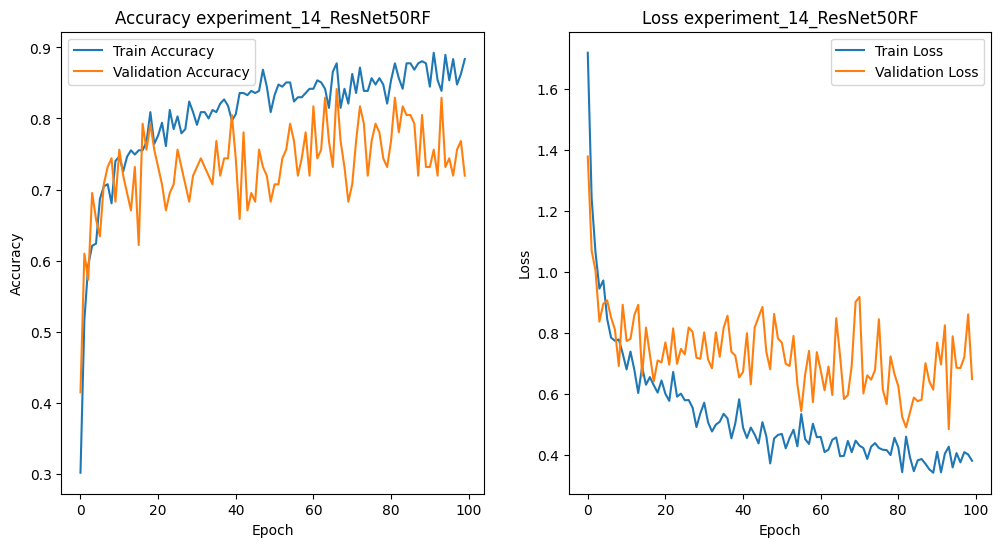

In [ ]:
def plot_history_from_csv(csv_path, plot_path):
    # Load training history from CSV
    history_df = pd.read_csv(csv_path)

    # Plot training and validation accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history_df['accuracy'], label='Train Accuracy')
    plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title(f"Accuracy {EXPERIMENT_NAME}")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history_df['loss'], label='Train Loss')
    plt.plot(history_df['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title(f"Loss {EXPERIMENT_NAME}")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # Save the plot
    plt.savefig(plot_path)
    plt.show()

# Call the function using CSV_LOG_PATH and PLOT_PATH
plot_history_from_csv(HISTORY_PATH, PLOT_PATH)


In [ ]:
def evaluate_model(model, test_ds):
    all_labels, all_preds = [], []
    inference_times = []  # List to store inference times

    for x, y in test_ds:
        start_time = time.time()  # Record start time
        preds = model.predict(x, verbose=1)
        end_time = time.time()  # Record end time
        inference_times.append(end_time - start_time)  # Calculate and store inference time

        all_preds.extend(np.argmax(preds, axis=1))
        all_labels.extend(y.numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    avg_inference_time = np.mean(inference_times)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Average Inference Time: {avg_inference_time:.4f} seconds")

    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

evaluate_model(model, test_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Accuracy: 0.9118
Precision: 0.9247
Recall: 0.9133
F1 Score: 0.9128
Average Inference Time: 1.5720 seconds
Confusion Matrix:
[[19  0  0  2  0]
 [ 0 19  0  1  0]
 [ 0  2 16  3  0]
 [ 0  1  0 19  0]
 [ 0  0  0  0 20]]
